In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

In [3]:
df = pd.read_csv('data.csv', encoding='utf-8-sig', index_col=0)
df_balanced = pd.read_csv('data_balanced.csv', encoding='utf-8-sig', index_col=0)

df_dropna = df.dropna()
df_balanced_dropna = df_balanced.dropna()

In [4]:
print("0 -> 그 외 지방: 강원, 충북, 충남, 전북, 전남, 경북, 경남, 제주")
print("1 -> 수도권 외 광역시: 부산, 대구, 광주, 대전, 울산")
print("2 -> 수도권 : 서울, 인천, 세종, 경기")
print()

region_counts = df['region'].value_counts()

total = df['region'].value_counts().sum()
for region, counts in enumerate(region_counts):
    print(f"{region} -> {counts} ({np.round(counts/total, 4)})")

0 -> 그 외 지방: 강원, 충북, 충남, 전북, 전남, 경북, 경남, 제주
1 -> 수도권 외 광역시: 부산, 대구, 광주, 대전, 울산
2 -> 수도권 : 서울, 인천, 세종, 경기

0 -> 1424 (0.4725)
1 -> 875 (0.2903)
2 -> 715 (0.2372)


### 상관계수 및 VIF 확인 & 가중치 감쇠를 통한 feature selection 시도

Sales-Employees 간의 양의 상관관계가 존재함을 확인

Accuracy :  0.43825665859564167
f1-score (macro) :  0.4361787015337925
Columns:  ['region' 'education' 'jobtype' 'cptype' 'sales' 'employees' 'aversalary'
 'capital' 'pros_encoded']
class  0
[ 0.01160984 -0.23243273 -0.07420711  0.02618456 -0.0795368  -0.11384987
 -0.00869283  0.01015937]
class  1
[ 0.05566591 -0.06288163 -0.25617227  0.02874468  0.0090184  -0.02997934
 -0.00395868 -0.4190372 ]
class  2
[-0.06727575  0.29531437  0.33037938 -0.05492924  0.0705184   0.14382922
  0.01265151  0.40887783]


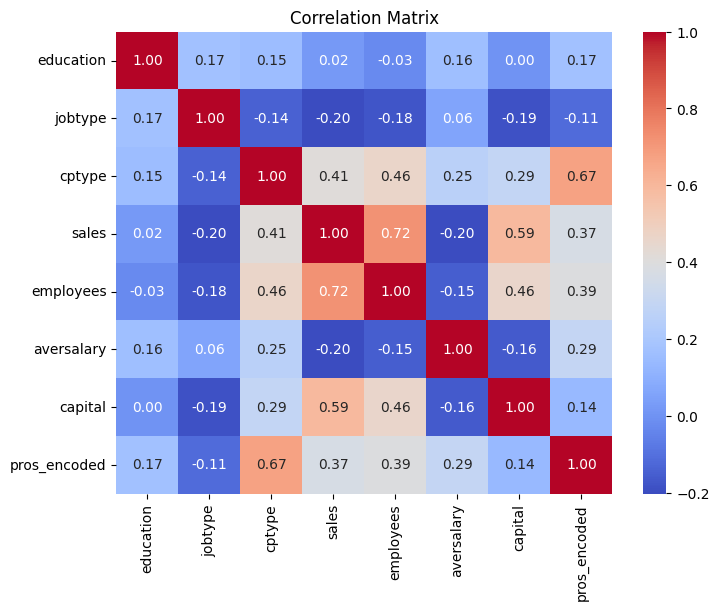

1.6784
1.6402
3.122
3.787
3.8644
1.5292
2.4003
2.3925


In [5]:
X_train = df_balanced_dropna.iloc[:, 1:]
y_train = df_balanced_dropna['region']

X_test = df_dropna.iloc[:, 1:]
y_test = df_dropna['region']

# Lasso classifier
# C is inverse of alpha
linear = LogisticRegression(penalty='l2', C=10)
linear.fit(X_train, y_train)

y_pred = linear.predict(X_test)

# Score
print("Accuracy : ", accuracy_score(y_test, y_pred))
print("f1-score (macro) : ", f1_score(y_test, y_pred, average='macro'))

# feature selection -> sales, employees, capital
print("Columns: ", df.columns.values)
for i in range(len(linear.coef_)):
    print("class ", i)
    coef_set = linear.coef_[i]
    print(coef_set)

# Correlation matrix
correlation_matrix = df.loc[:, 'education': 'pros_encoded'].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# VIF
for feature in range(len(df.columns[1:])):
    print(np.round(variance_inflation_factor(X_train, feature), 4))

### 결측값이 존재하는 행 탐색

In [6]:
nan_rows = df.isna().any(axis=1)

df_nan = df[nan_rows]

print(df_nan.describe())

df_nan.head()

            region    education      jobtype       cptype       sales  \
count  1362.000000  1362.000000  1362.000000  1362.000000  600.000000   
mean      0.734949     0.780470     0.464023     0.461821    6.692517   
std       0.781545     1.153011     0.498887     0.769799   12.811688   
min       0.000000     0.000000     0.000000     0.000000   -0.130200   
25%       0.000000     0.000000     0.000000     0.000000   -0.127200   
50%       1.000000     0.000000     0.000000     0.000000    0.000000   
75%       1.000000     1.000000     1.000000     1.000000    5.933400   
max       2.000000     5.000000     1.000000     2.000000   95.856900   

        employees  aversalary    capital  pros_encoded  
count  829.000000  497.000000  650.00000   1362.000000  
mean     1.230340   -0.180477   68.75026     -0.095374  
std      4.171746    0.626951  188.54690      0.536237  
min     -0.209200   -1.521700   -0.11300     -0.500000  
25%     -0.203600   -0.565200   -0.11070     -0.500000  


,region,education,jobtype,cptype,sales,employees,aversalary,capital,pros_encoded
2,2,0,0,0,95.8569,10.7799,0.8261,NaN,0.95
3,2,0,1,1,21.3606,12.3409,NaN,NaN,0.40
6,2,0,1,0,NaN,NaN,NaN,NaN,0.05
7,2,1,1,1,1.3717,0.8855,1.5652,NaN,0.60
13,2,0,1,2,0.3120,-0.0272,NaN,5.8862,1.00


<h5> 대부분의 결측값은 중소기업에 해당함을 확인 </h5>

In [7]:
print("지역에 따른 결측값 분포: \n", df_nan['region'].value_counts())
print("회사 규모에 따른 결측값 분포: \n", df_nan['cptype'].value_counts())

지역에 따른 결측값 분포: 
 region
0    644
1    435
2    283
Name: count, dtype: int64
회사 규모에 따른 결측값 분포: 
 cptype
0    967
2    234
1    161
Name: count, dtype: int64


### Xgboost classifier


### Balanced dataset (undersampling) - No drop na  

결측값에도 필요한 정보가 존재할 수 있다고 생각되므로 단순히 drop 처리하기 껄끄럽다,    
결측값에 대한 별도 처리가 필요없는 Xgboost Classifier 모델 사용

In [8]:
X_train = df_balanced.iloc[:, 1:]
y_train = df_balanced['region']

X_test = df.iloc[:, 1:]
y_test = df['region']

xgb_clf = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    objective="multi:softmax",
    num_class=3,
    eval_metric=["mlogloss"],
)

xgb_clf.fit(
    X_train,
    y_train,
    verbose=0,  # set to 1 to see xgb training round intermediate results
    eval_set=[(X_train, y_train), (X_test, y_test)],
)

y_pred = xgb_clf.predict(X_test)

print(f"accuracy: ", accuracy_score(y_test, y_pred))
print("f1-score (macro) : ", f1_score(y_test, y_pred, average='macro'))

accuracy:  0.5454545454545454
f1-score (macro) :  0.5448981962347432


### 특정 class 로 예측이 편향되지 않았는지 확인

value_counts of y_test
 [1424  875  715]
value_counts of y_pred
 [1099 1070  845]


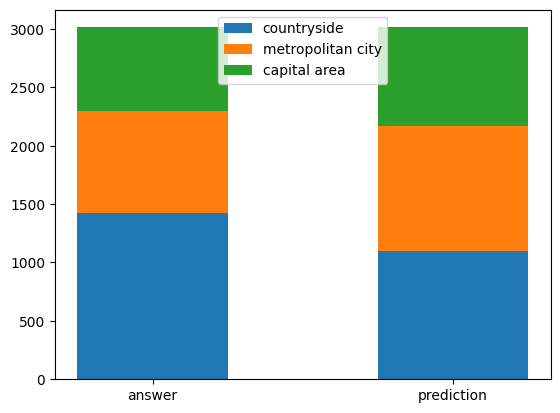

In [9]:
print("value_counts of y_test\n", np.array(y_test.value_counts()))
print("value_counts of y_pred\n", np.bincount(y_pred))

x = pd.DataFrame(
    {
        "y_test": np.array(y_test.value_counts()),
        "y_pred": np.bincount(y_pred),
    }
)

value_sets = {
    "countryside": x.iloc[0].values,
    "metropolitan city": x.iloc[1].values,
    "capital area": x.iloc[2].values,
}

fig, ax = plt.subplots()
bottom = np.zeros(2)

label = ("answer", "prediction")

for region, value_set in value_sets.items():
    ax.bar(label, value_set, width=0.5, label=region, bottom=bottom)
    bottom += value_set

ax.legend(loc="upper center")
plt.show()

### Balanced dataset (undersampling) , 결측값 drop 시

Accuracy, F1-score 증가

In [10]:
X_train = df_balanced_dropna.iloc[:, 1:]
y_train = df_balanced_dropna['region']

X_test = df_dropna.iloc[:, 1:]
y_test = df_dropna['region']

xgb_clf = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    objective="multi:softmax",
    num_class=3,
    eval_metric=["mlogloss"],
)

xgb_clf.fit(
    X_train,
    y_train,
    verbose=0,  # set to 1 to see xgb training round intermediate results
    eval_set=[(X_train, y_train), (X_test, y_test)],
)

y_pred = xgb_clf.predict(X_test)

print("accuracy: ", accuracy_score(y_test, y_pred))
print("f1-score (macro) : ", f1_score(y_test, y_pred, average='macro'))

accuracy:  0.6077481840193705
f1-score (macro) :  0.6015993667993077


### 마찬가지로 예측 클래스 분포가 편향되지 않았는지 확인  
예측값이 "capital area" 쪽으로 편향됨을 확인할 수 있었다.    

drop 하면서 제거된 행데이터들의 분포는 주로 region 0 (지방), cptype 0 (중소기업)  
따라서 drop 하면서 오히려 학습 데이터가 Imbalanced 해졌다고 분석된다.

value_counts of y_test
 [780 440 432]
value_counts of y_pred
 [647 408 597]


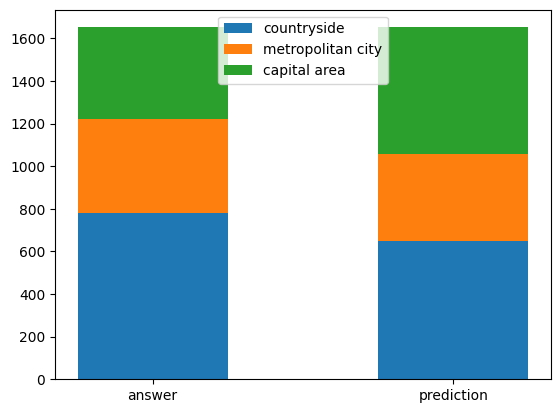

In [11]:
print("value_counts of y_test\n", np.array(y_test.value_counts()))
print("value_counts of y_pred\n", np.bincount(y_pred))

x = pd.DataFrame(
    {
        "y_test": np.array(y_test.value_counts()),
        "y_pred": np.bincount(y_pred),
    }
)

value_sets = {
    "countryside": x.iloc[0].values,
    "metropolitan city": x.iloc[1].values,
    "capital area": x.iloc[2].values,
}

fig, ax = plt.subplots()
bottom = np.zeros(2)

label = ("answer", "prediction")

for region, value_set in value_sets.items():
    ax.bar(label, value_set, width=0.5, label=region, bottom=bottom)
    bottom += value_set

ax.legend(loc="upper center")
plt.show()

### 최종 모델에 사용할 데이터셋 확정  
Undersampling 적용, dropna X

In [12]:
X_train = df_balanced.iloc[:, 1:]
y_train = df_balanced['region']

X_test = df.iloc[:, 1:]
y_test = df['region']

### 하이퍼 파라미터 튜닝

아래 코드 실행시 결과  
Best Parameters:  {'n_estimators': 80, 'max_depth': 4, 'learning_rate': 0.14}  
Best Score:  0.5174024741001367  

In [13]:
# param_dist = {
#     'n_estimators' : np.arange(10, 210, 10),
#     'learning_rate' : np.arange(0, 1, 0.02),
#     'max_depth' : np.arange(1, 5),
# }

# xgb_clf = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric=['mlogloss'],)


# xgb_clf_tuned = RandomizedSearchCV(xgb_clf, param_distributions=param_dist, n_iter=100, random_state=4885, cv=3)

# xgb_clf_tuned.fit(X_train, y_train)

# print("Best Parameters: ", xgb_clf_tuned.best_params_)
# print("Best Score: ", xgb_clf_tuned.best_score_)

### 튜닝된 모델로 예측 및 예측결과 시각화  

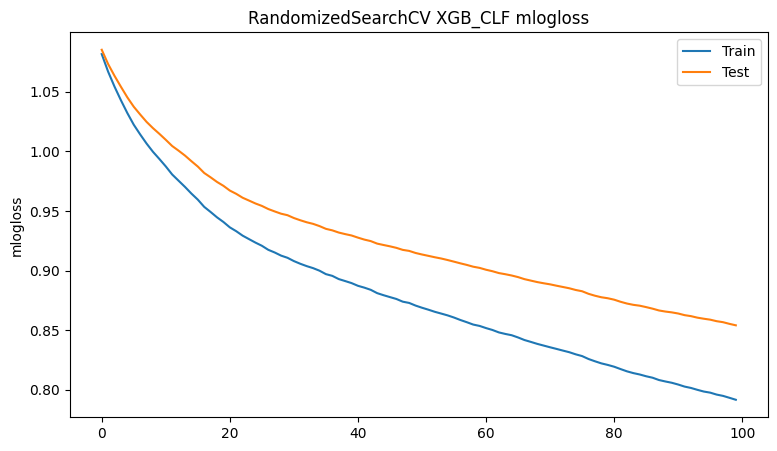

acc:  0.6091572660915726
f1-score (macro) :  0.6099482682403785


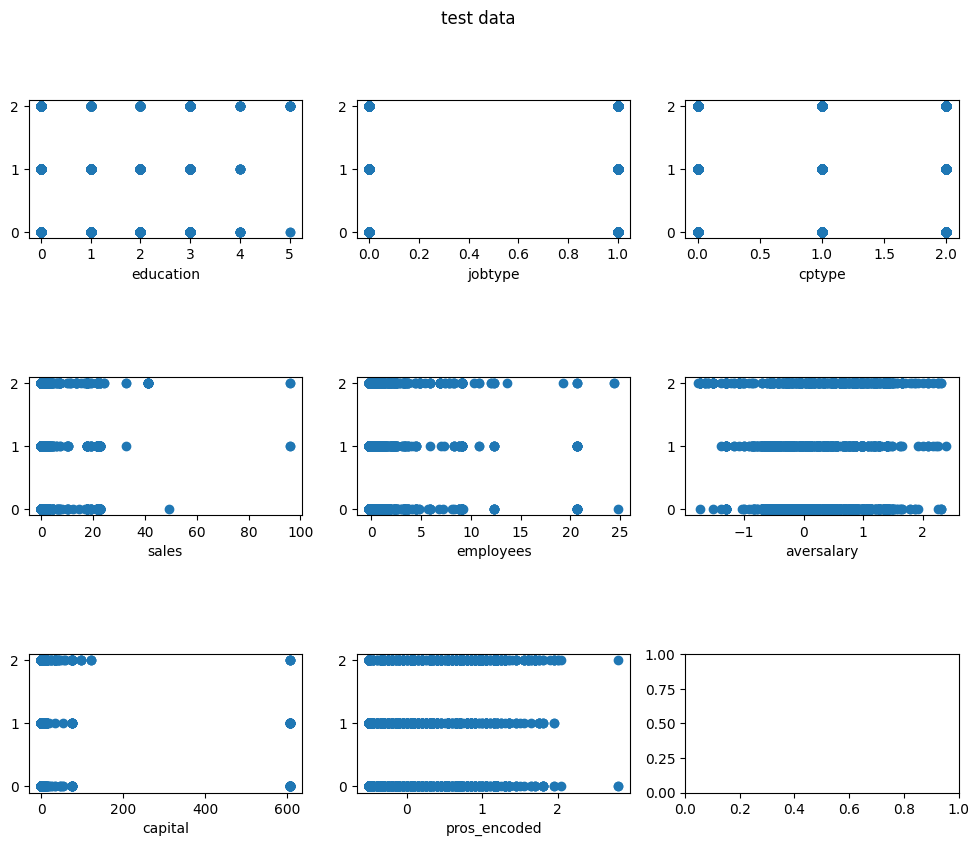

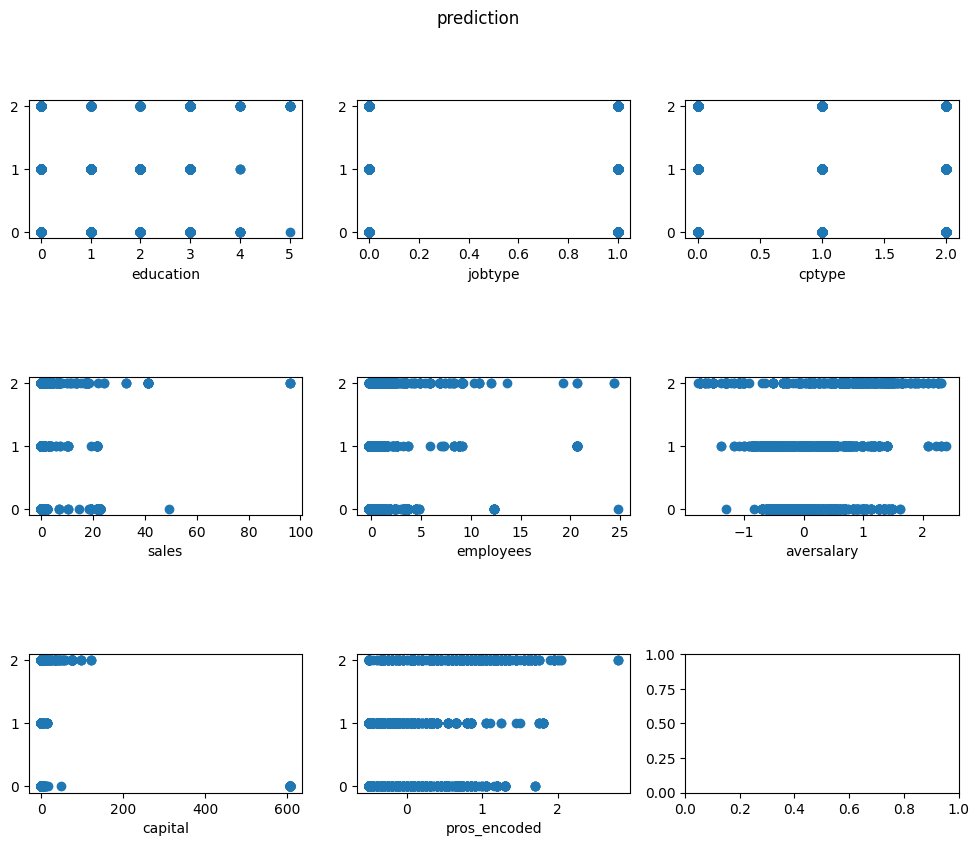

In [14]:
xgb_clf_tuned = XGBClassifier(
    objective='multi:softmax', 
    num_class=3, 
    eval_metric=['mlogloss'],
    n_estimators = 80,
    max_depth = 4,
    learning_rate = 0.14,
    )

xgb_clf_tuned.fit(X_train, 
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            eval_set=[(X_train, y_train), (X_test, y_test)])

# ----- 학습 epoch 당 모델 score (여기서는 mlogloss) 변화 시각화 -----
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('RandomizedSearchCV XGB_CLF mlogloss')
plt.show()

y_pred = xgb_clf_tuned.predict(X_test)

print("acc: ", accuracy_score(y_test, y_pred))
print("f1-score (macro) : ", f1_score(y_test, y_pred, average='macro'))

# ----- X_test - y_test 산점도 -----
features = df.columns[1:]

fig, axes = plt.subplots(nrows= 3, ncols=3, figsize=(12, 9))

fig.subplots_adjust(hspace=1, wspace=0.2)
for feature_idx in range(len(features)):
    axe_row = feature_idx // 3
    axe_col = feature_idx % 3
    axes[axe_row, axe_col].scatter(X_test[features[feature_idx]], y_test)
    axes[axe_row, axe_col].set_xlabel(features[feature_idx])
plt.suptitle("test data")
plt.show()

# ----- X_test - y_pred 산점도 -----
fig, axes = plt.subplots(nrows= 3, ncols=3, figsize=(12, 9))
fig.subplots_adjust(hspace=1, wspace=0.2)
for feature_idx in range(len(features)):
    axe_row = feature_idx // 3
    axe_col = feature_idx % 3
    axes[axe_row, axe_col].scatter(X_test[features[feature_idx]], y_pred)
    axes[axe_row, axe_col].set_xlabel(features[feature_idx])

plt.suptitle("prediction")
plt.show()

### 예측 클래스가 편향된 정도 확인

value_counts of y_test
 [1424  875  715]
value_counts of y_pred
 [1181 1091  742]


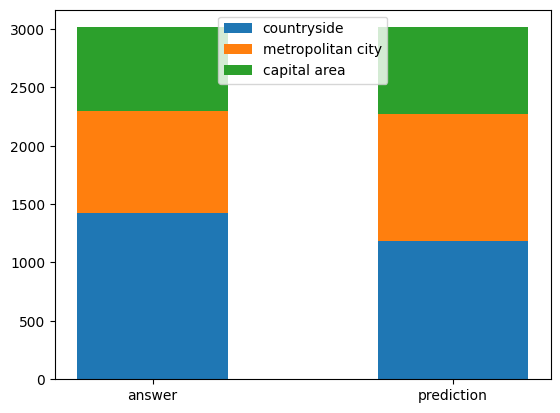

In [15]:
print("value_counts of y_test\n", np.array(y_test.value_counts()))
print("value_counts of y_pred\n", np.bincount(y_pred))

x = pd.DataFrame(
    {
        "y_test": np.array(y_test.value_counts()),
        "y_pred": np.bincount(y_pred),
    }
)

value_sets = {
    "countryside": x.iloc[0].values,
    "metropolitan city": x.iloc[1].values,
    "capital area": x.iloc[2].values,
}

fig, ax = plt.subplots()
bottom = np.zeros(2)

label = ("answer", "prediction")

for region, value_set in value_sets.items():
    ax.bar(label, value_set, width=0.5, label=region, bottom=bottom)
    bottom += value_set

ax.legend(loc="upper center")
plt.show()

In [16]:
from xgboost import plot_tree

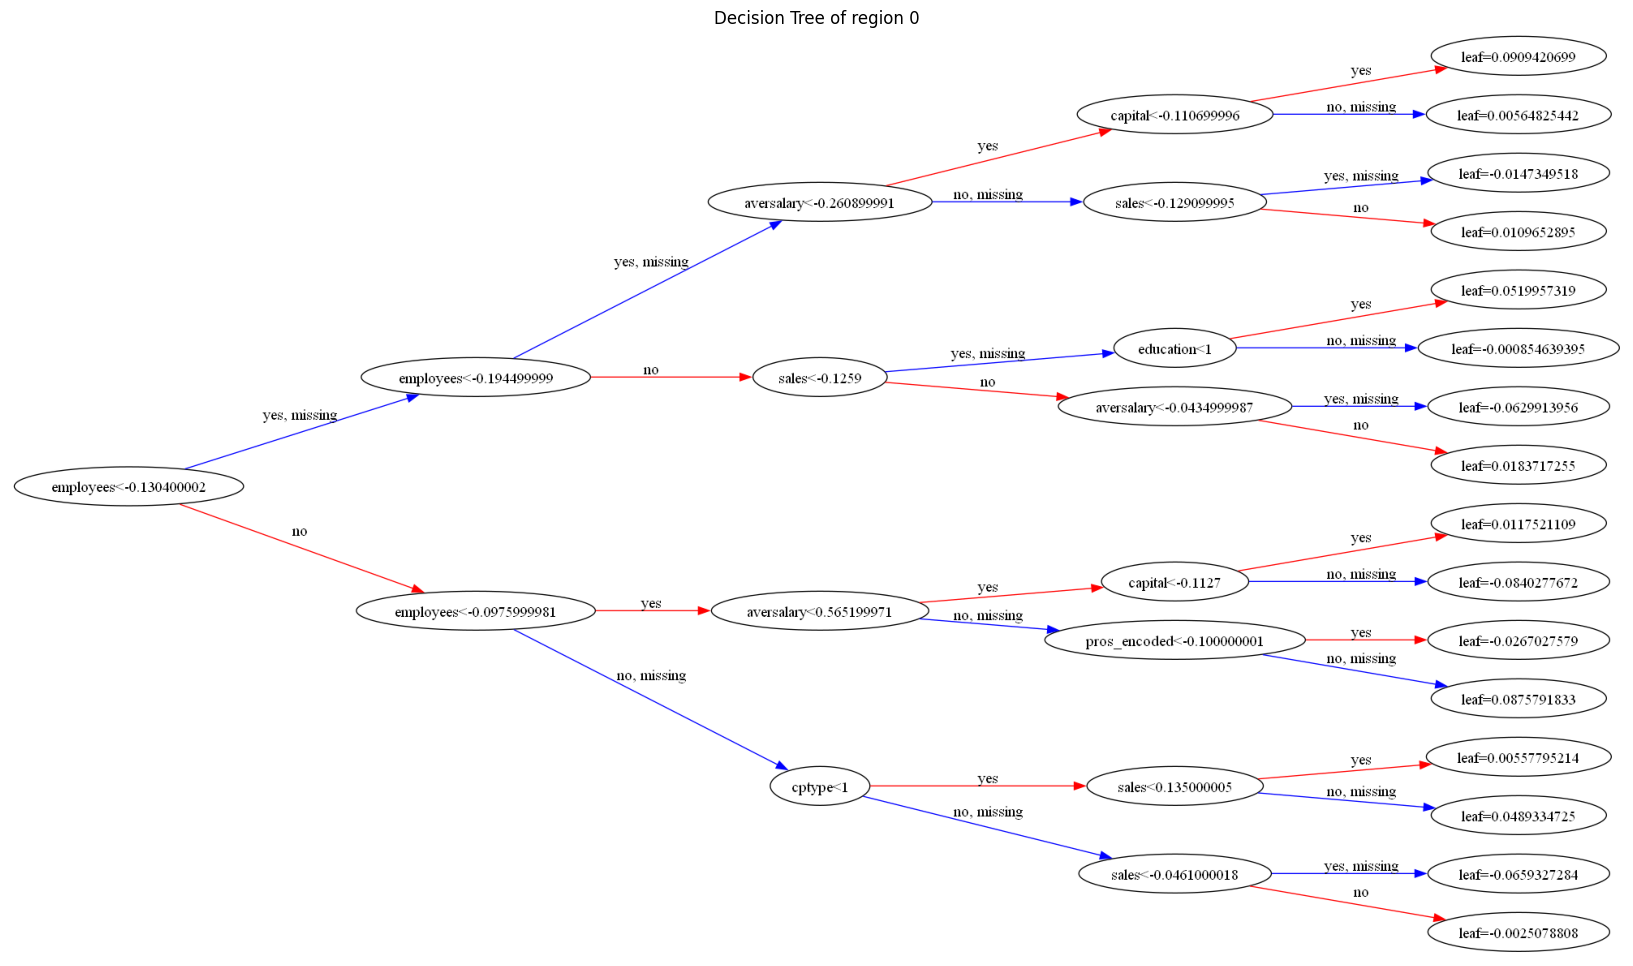

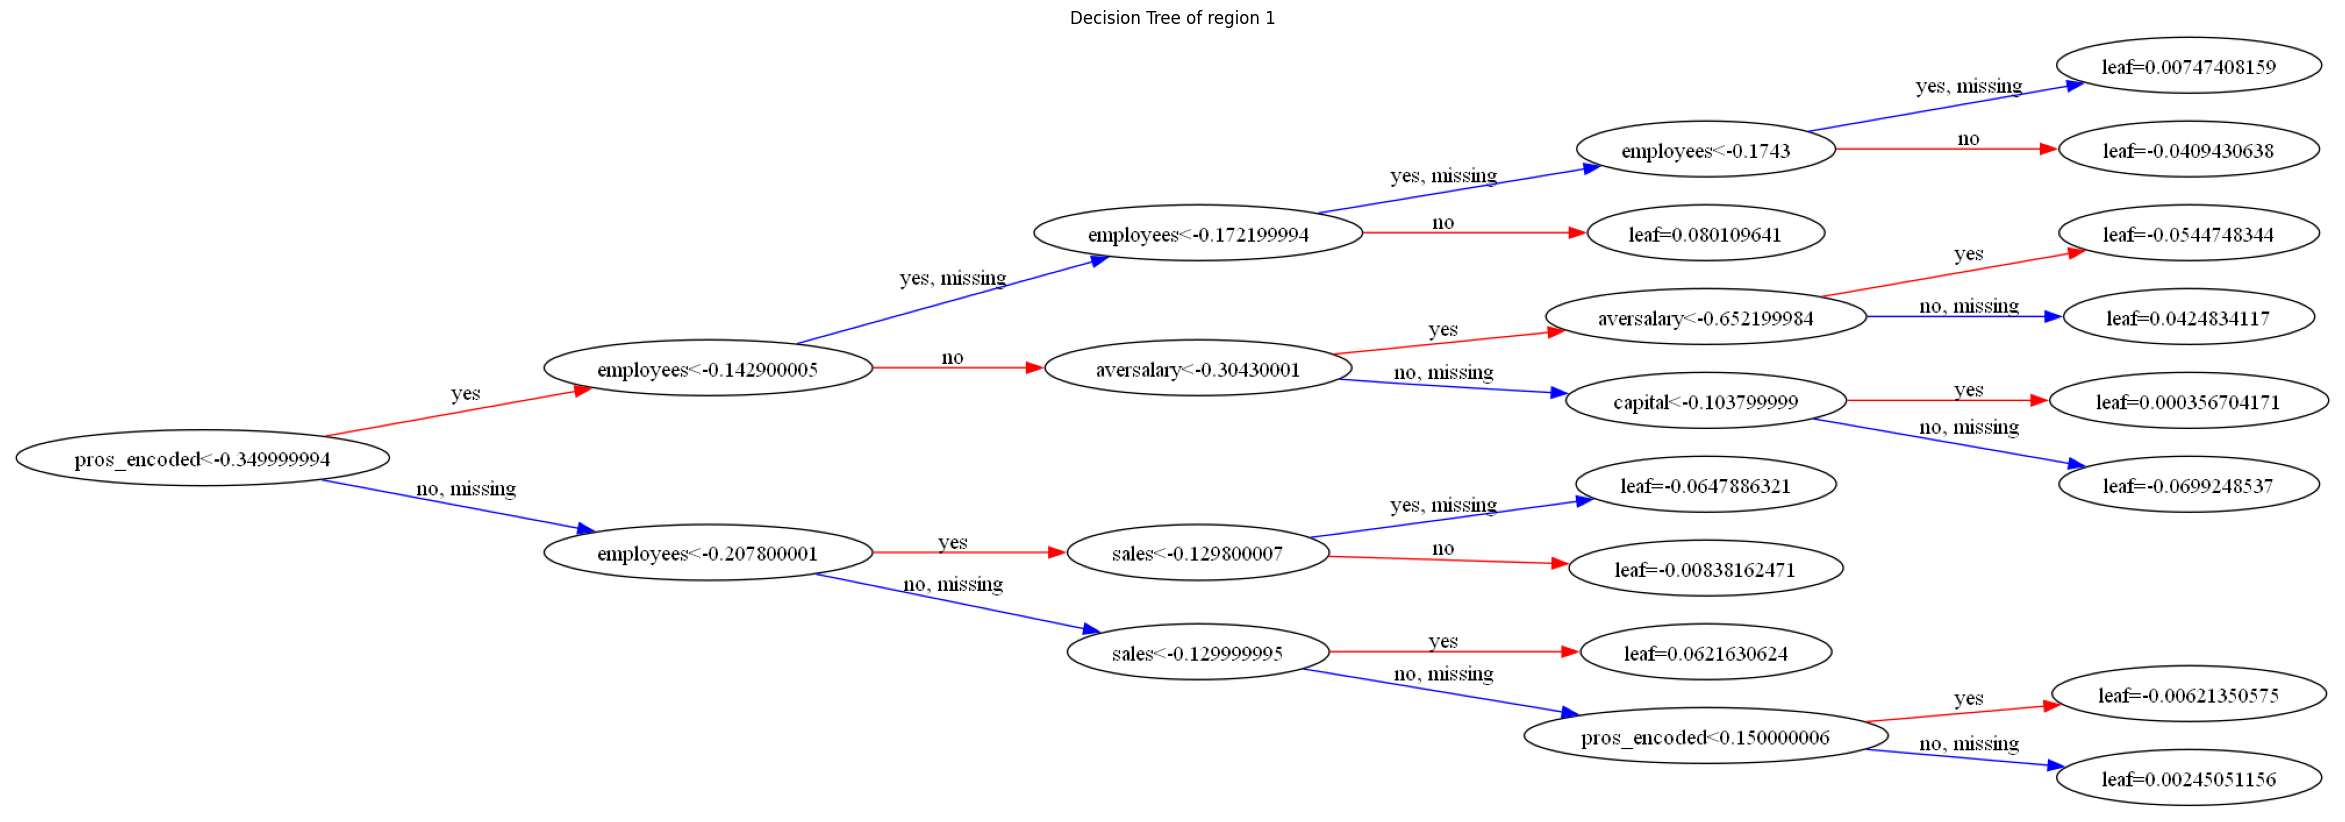

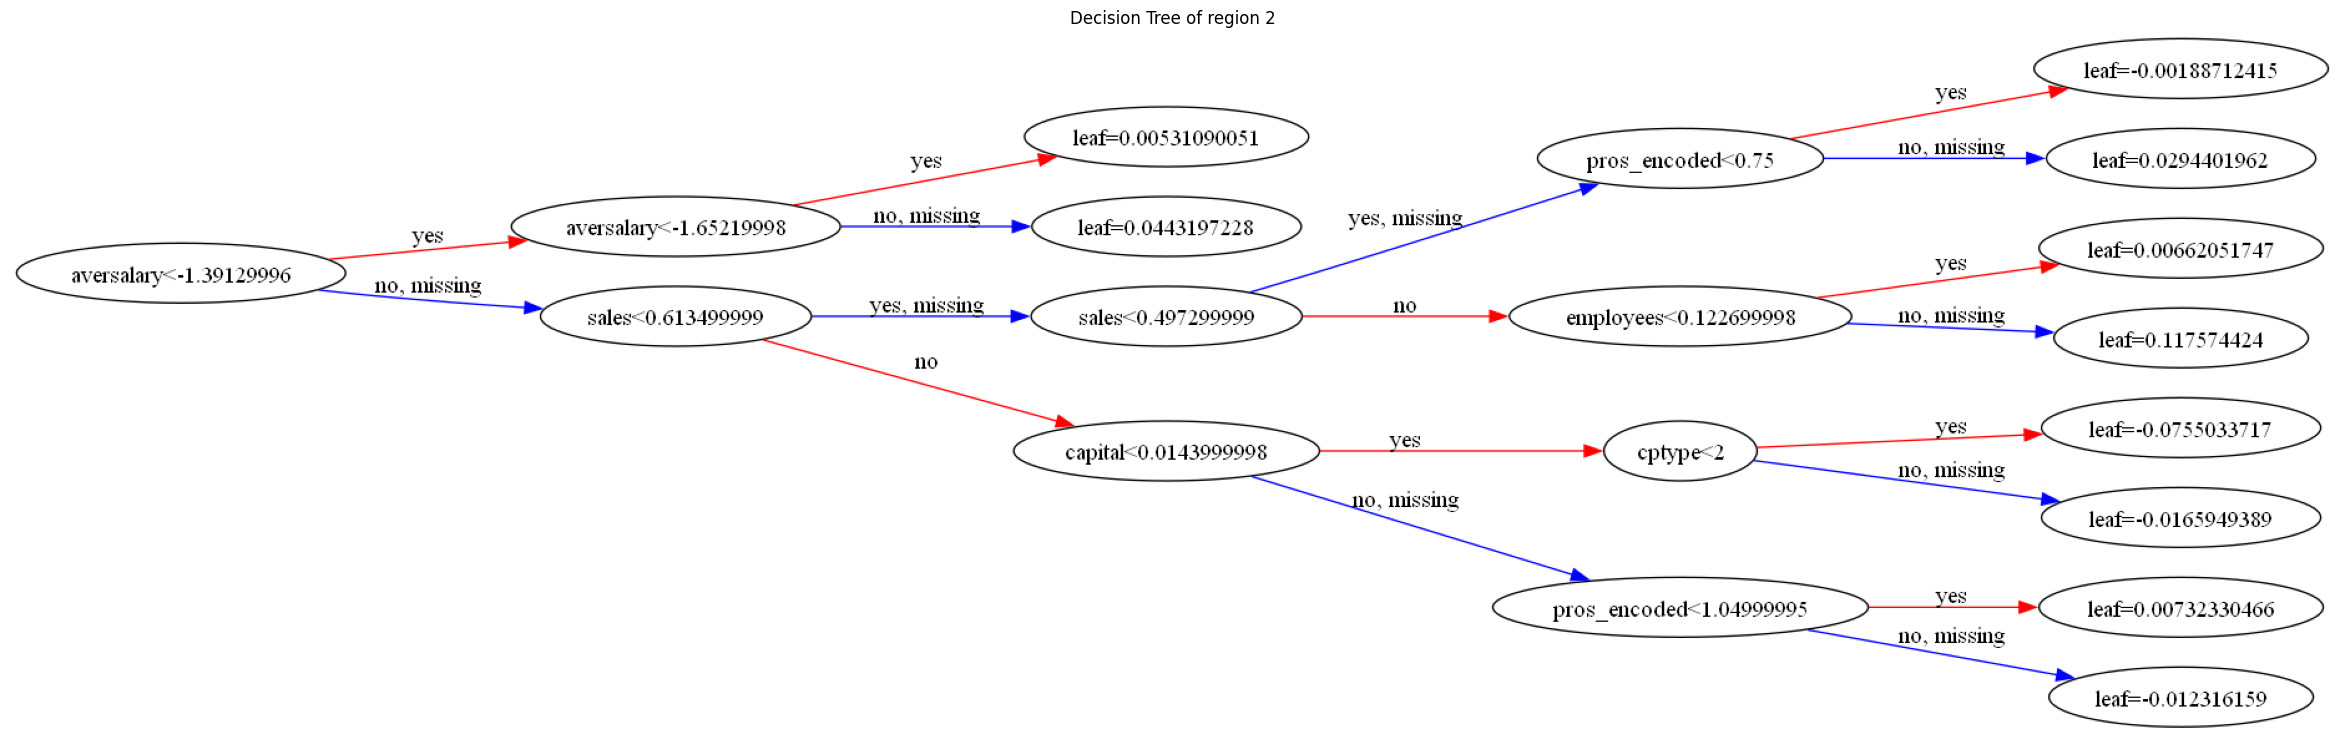

In [17]:
# best_params
# {'n_estimators': 80, 'max_depth': 4, 'learning_rate': 0.14}

for class_region in [0, 1, 2]:
    # num_tree 는 best_params 에 맞춰 하드 코딩된 값
    num_tree = (class_region * 80) + 79

    # rankdir="LR" : 왼쪽에서 오른쪽 방향으로 트리를 보여준다.
    plot_tree(xgb_clf_tuned, num_trees=num_tree, rankdir='LR')
    fig = plt.gcf()
    fig.set_size_inches(30, 12)

    # 이미지 저장
    fig.savefig(f'tree_class{class_region}.png')

    plt.title(f'Decision Tree of region {class_region}')
    plt.show()

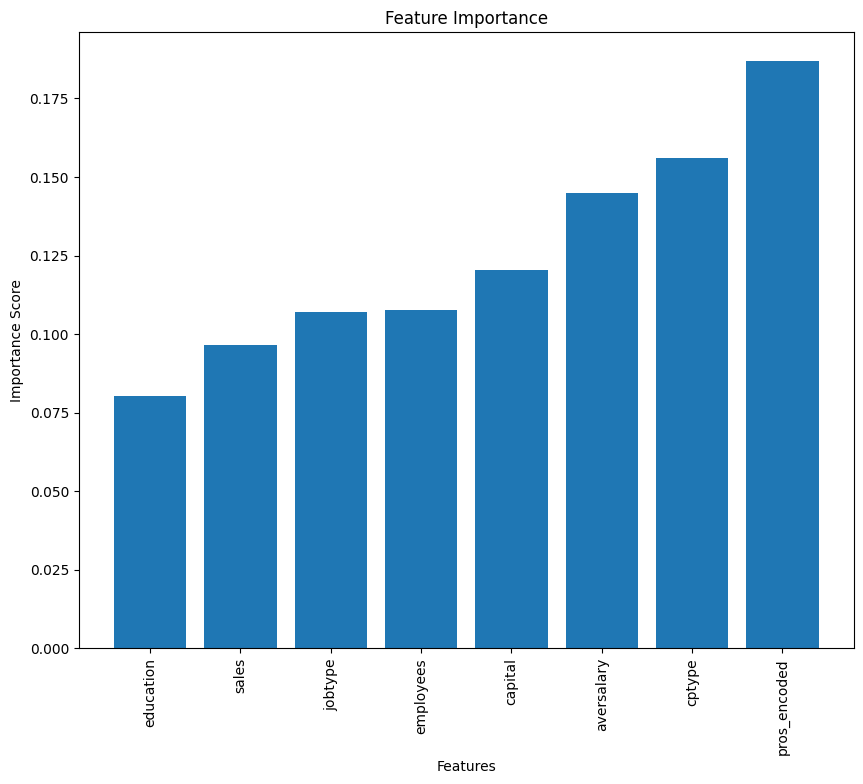

In [18]:
feature_importance = xgb_clf_tuned.feature_importances_
# 오름차순 정렬 시 인덱스
sorted_idx = np.argsort(feature_importance)

X = df.iloc[:, 1:]

plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.xticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx], rotation=90)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()

결측값이 존재하는 상태 (종속변수에는 결측값이 존재하지 않는다.) 에서 언더샘플링 한 데이터를 모델학습에 사용하였다.  
또한, 결측값을 포함해 학습하기 위해 xgboost 사용하였다.  

해당 모델을 사용하여 '구인 공고에 등록된 정보' 를 가지고 '구인 공고가 올라온 지역' 을 예측한 결과,  
무작위 예측 시 정확도 약 0.3637 와, 무조건 '지방 지역' 으로 예측하는 모델 정확도 0.4725 비해 소폭 높은 테스트 정확도 약 0.609 를 기록하였다.  
해당 모델의 f1-score 는 약 0.610 이었다.  

무작위 예측을 하는 모델과 무조건 다수 클래스로 예측하는 모델보다는 확실히 성능이 뛰어나다는 점을 감안하여  
##### < 1. 구인 공고 데이터로 지역 예측이 가능할 것이다 (지도학습). > 는 어느 정도는 맞는 것으로 판단하고자 한다.  

## 가설 검정  
검정 과정 이전에 결측값 처리가 필요하므로, 모델학습에 사용한 것과 달리 결측값은 모두 drop 처리하였다.

Index(['region', 'education', 'jobtype', 'cptype', 'sales', 'employees',
       'aversalary', 'capital', 'pros_encoded'],
      dtype='object')
region
0    1424
1     876
2     715
Name: count, dtype: int64


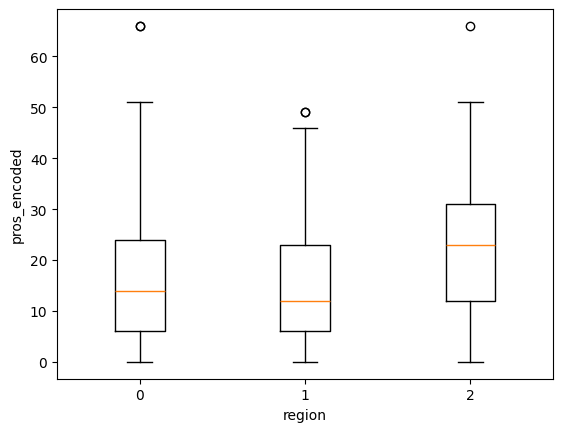

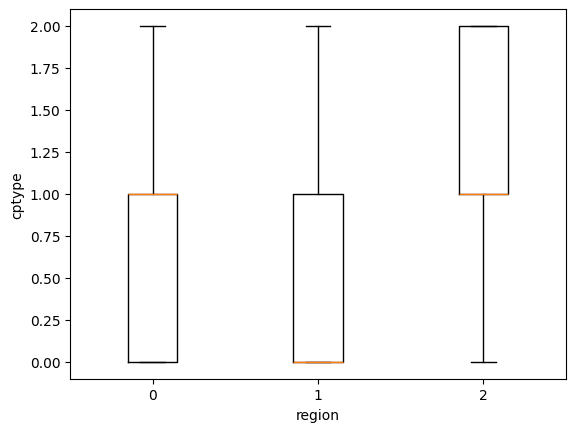

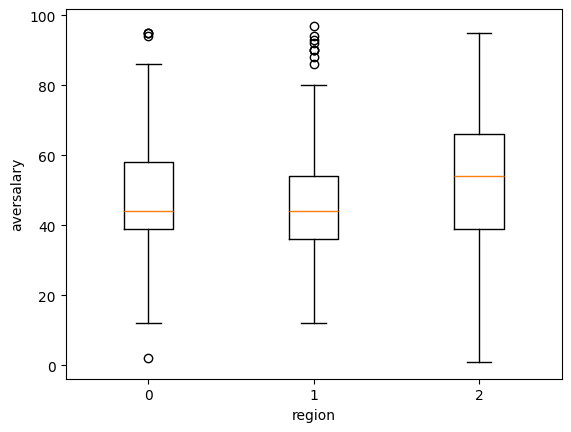

In [26]:
df = pd.read_csv('data_beforeScaling.csv', encoding='utf-8-sig', index_col=0)

print(df.columns)
print(df['region'].value_counts())

region_0 = df_dropna[df_dropna['region'] == 0]
region_1 = df_dropna[df_dropna['region'] == 1]
region_2 = df_dropna[df_dropna['region'] == 2]

# 튜닝된 XgboostClassifier 에서 feature importance 상위 3개 Numeric type 항목
features = ['pros_encoded', 'aversalary', 'capital']

for feature in features:
    plot_data = [region_0[feature], region_1[feature], region_2[feature]]
    ax = plt.boxplot(plot_data, labels=[0, 1, 2])
    plt.xlabel("region")
    plt.ylabel(feature)
    plt.show()

### 검정

튜닝된 XgboostClassifier 에서 feature importance 상위 3개 Numeric 피쳐 ['pros_encoded', 'aversalary', 'capital'] 에 대해 One-way ANOVA 검정 수행  
표본평균이 통계적으로 유의미한 수준으로 차이남을 확인  

정규성은 만족하지 않으나, bartlett's test 를 통해 등분산성 확인.

In [21]:
from scipy import stats

In [22]:
features = ['pros_encoded', 'aversalary', 'capital']

print("정규성 만족 확인")
# pvalue > 0.05 이상이면 정규성 만족
for feature in features:
    print(feature)
    print(stats.shapiro(region_0[feature]).pvalue)
    print(stats.shapiro(region_1[feature]).pvalue)
    print(stats.shapiro(region_2[feature]).pvalue)

print("num_region0 : ", len(region_0))
print("num_region1 : ", len(region_1))
print("num_region2 : ", len(region_2))

# 정규성은 만족하지 않으나, 비모수 검정보다 모수 검정이 더 유효하다고 판단
# 중심 극한 정리에 의해 정규성을 따르지 않더라도 모수적 검정 가능하다는 글을 참고하였다.
# reference : https://blog.minitab.com/ko/adventures-in-statistics-2/choosing-between-a-nonparametric-test-and-a-parametric-test
# https://statisticsbyjim.com/hypothesis-testing/nonparametric-parametric-tests/

print("\n등분산성 확인 (bartlett's test)")
# 등분산성 확인
for feature in features:
    print(feature)
    # bartlett 검정에서 p-value 가 작다면 등분산성일 가능성이 낮다
    # ref. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bartlett.html#scipy.stats.bartlett
    print(stats.bartlett(stats.shapiro(region_0[feature]), 
                       stats.shapiro(region_1[feature]), 
                       stats.shapiro(region_2[feature])).pvalue)

print("\none-way ANOVA")
for feature in features:
    print(feature)
    print(stats.f_oneway(region_0[feature], region_1[feature], region_2[feature]))

정규성 만족 확인
pros_encoded
2.0417284676573435e-15
6.11914401374466e-14
4.077762406006191e-06
aversalary
4.327476979636317e-11
7.007666815514323e-07
8.01951850755442e-12
capital
4.7615466119399145e-49
3.844996469191931e-39
2.600756162531475e-34

등분산성 확인 (bartlett's test)
pros_encoded
0.9989575089562657
aversalary
0.9995357888129095
capital
0.7613775291558502

one-way ANOVA
pros_encoded
F_onewayResult(statistic=54.41740370023299, pvalue=1.3002302415233098e-23)
aversalary
F_onewayResult(statistic=5.923315229931658, pvalue=0.002733589619109128)
capital
F_onewayResult(statistic=29.428691826038236, pvalue=2.767483257396838e-13)


### ANOVA test 후 사후 검정

<검정 결과>  
[pros_encoded]  

지역마다 통계적으로 유의미한 수준으로 차이난다.

[aversalary]  

(지방 - 비수도권 광역시), (지방 - 수도권) 의 차이는 무의미하다. 비수도권 광역시-수도권 의 차이는 유의미하다.  

평균연봉에 대해서는 예상한 것과 달리 지방과 수도권의 차이가 가장 크게 나타나지 않았다.  
단순히 각 그룹 통계량 상으로도 [수도권 평균연봉 > 지방 평균연봉 > 비수도권 광역시 평균 연봉] 의 관계를 보였다.  

[capital]  

지방 - 비수도권 광역시 차이는 크게 무의미하다. (수도권-비수도권 광역시), (수도권-지방) 의 차이는 크게 유의미하다.  
수도권에 대기업이 집중되는 경향이 있다보니 해당 분석 결과가 나온 것으로 생각된다.  

In [24]:
import scikit_posthocs as sp

print("### scheffe's test ###")

features = ['pros_encoded', 'aversalary', 'capital']

for feature in features:
    x = pd.DataFrame({'0':region_0[feature].reset_index(drop=True), 
                      '1':region_1[feature].reset_index(drop=True), 
                      '2':region_2[feature].reset_index(drop=True)})

    x = x.melt(var_name='region', value_name=feature)

    x = x.dropna() # 지역마다 표본 수 동일

    # scheffe's test
    print("\n",feature)
    print(sp.posthoc_scheffe(x, val_col=feature, group_col='region'))

### scheffe's test ###

 pros_encoded
              0             1             2
0  1.000000e+00  1.517594e-02  1.938339e-15
1  1.517594e-02  1.000000e+00  1.842321e-21
2  1.938339e-15  1.842321e-21  1.000000e+00

 aversalary
          0         1         2
0  1.000000  0.197034  0.112865
1  0.197034  1.000000  0.002768
2  0.112865  0.002768  1.000000

 capital
              0             1             2
0  1.000000e+00  9.450213e-01  4.857861e-12
1  9.450213e-01  1.000000e+00  7.757975e-09
2  4.857861e-12  7.757975e-09  1.000000e+00


In [25]:
print(region_0['aversalary'].mean())
print(region_1['aversalary'].mean())
print(region_2['aversalary'].mean())

47.787179487179486
45.925
49.958333333333336


<한계점 분석>  
수집한 데이터의 품질이 떨어져서 문제의 본질인 일자리의 '질적 평가'를 원하는 수준만큼 정확하게 내리지 못하였다.

구인 공고에서 가장 중요하다고 생각하는 연봉정보는 대부분 '회사 내규' 혹은 간혹 있더라도 이미지 내에 표시되어 있어 크롤랑하여 사용하지 못하였다.  
또한, 회사 재정정보는 회사마다 최신화된 정보가 아닌 경우가 대부분이었다.  
이러한 이유로 인해 구인 공고 데이터를 통해 해당 일자리가 질적으로 우수한지 원하는 수준만큼 정확하게 평가하지 못하고 있다고 생각한다.